In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from Games import *
import Utility
from os import listdir
from os.path import join
from json import load
from glob import glob

In [3]:
PALETTE = {
    "policy": "red", 
    "q": "blue", 
    "random": "green", 
    "GreedyRelative": "purple"
}

In [4]:
def get_agent_playthroughs(config, allow_empty_link):
    playthroughs = []
    for filename in listdir(config.BASE_DIR):
        if filename.startswith('fitagent_playthrough_') and str(allow_empty_link) in filename:
            with open(join(config.BASE_DIR, filename), 'r') as f:
                data = load(f)
                playthroughs.append((filename, data))
            
    return playthroughs

In [5]:
def get_player_playthroughs(config, player_name):
    playthroughs = []
    starts_with_str = f'player_{player_name}_fit_playthrough_{config.NAME}'
    
    for filename in listdir(config.BASE_DIR):
        if filename.startswith(starts_with_str):
            with open(join(config.BASE_DIR, filename), 'r') as f:
                data = load(f)
                playthroughs.append((filename, data))
            
    return playthroughs

In [6]:
def heatmap(playthrough_data, graph, filename, bounds):
    max_x, max_y = bounds
    data = np.zeros((max_x + 1, max_y + 1))
    mask = np.ones((max_x + 1, max_y + 1))
    for n in graph.nodes:
        if '__' in n:
            continue
            
        a,b,_ = n.split(',')
        mask[int(a)][int(b)] = 0.0
    
    for run in playthrough_data:
        for segment, _, _, _ in run:
            if '__' in segment:
                continue
                
            a, b, _ = segment.split(',')
            data[int(a)][int(b)] += 1.0
    
    sns.set(rc = {'figure.figsize':(8,4)})
    ax = sns.heatmap(
        data, 
        mask=mask,
        square=True,
        cmap='Blues'
    )
#     ax = sns.heatmap(data, square=True)
    ax.invert_yaxis()
    ax.set_title(filename)
    ax.set_facecolor("gray")
    
    # reduce frequency for xticks
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 5 == 0:  
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    # reduce frequency for y ticks
    for ind, label in enumerate(ax.get_yticklabels()):
        if ind % 5 == 0:  
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.show()

In [7]:
def plot_reward_over_time(playthroughs):
    plot_data = {}
    for filename, data in playthroughs:
        legend_name = filename.split('.')[0].split('_')[-2]
        plot_data[legend_name] = []
        total_reward = 0
        
        for level in data:
            for _, _, _, r in level:
                total_reward += r
            
            plot_data[legend_name].append(total_reward)
    
    sns.set(rc = {'figure.figsize':(15,8)})
    ax = sns.lineplot(data=plot_data, palette=PALETTE)
    ax.set_title('Reward over Time')
        
    plt.show()

## Agent :: DungeonGrams

In [8]:
config = DungeonGrams
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config, False)

Loading links from: ./GramElitesData/DungeonData/gram_elites/links_True.json


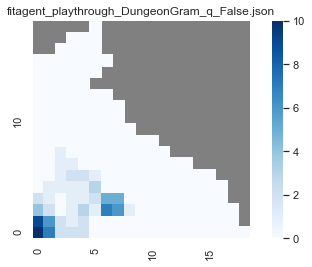

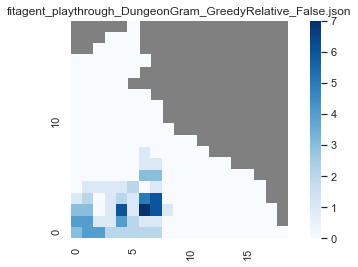

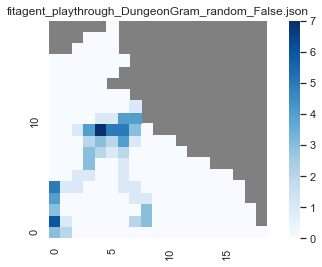

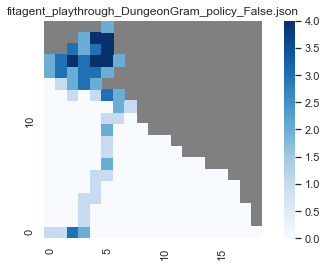

In [9]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

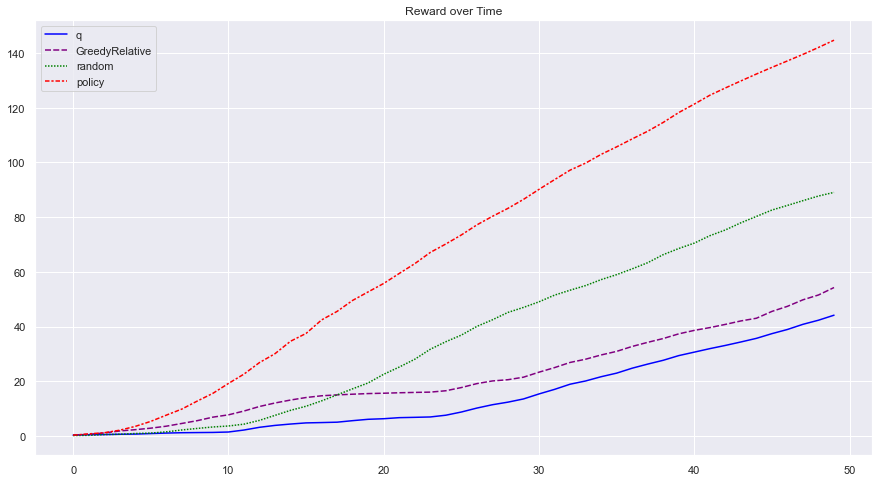

In [10]:
plot_reward_over_time(playthroughs)

## Agent :: DungeonGrams + Food

In [11]:
config = DungeonGrams
graph = Utility.get_graph(config, False)
playthroughs = get_agent_playthroughs(config, False)

Loading links from: ./GramElitesData/DungeonData/gram_elites/links_False.json


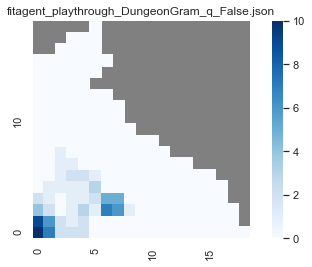

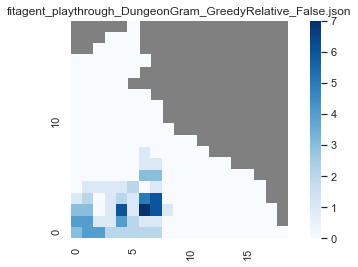

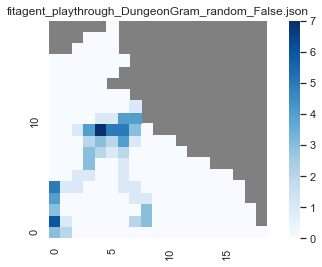

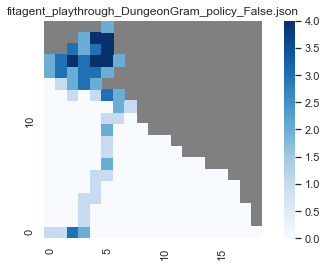

In [12]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

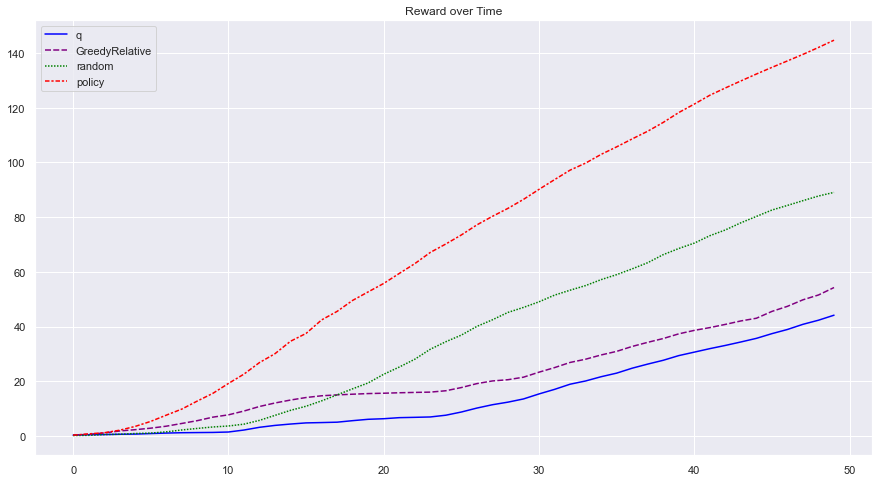

In [13]:
plot_reward_over_time(playthroughs)

## Agent :: Mario

In [14]:
config = Mario
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config, True)

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


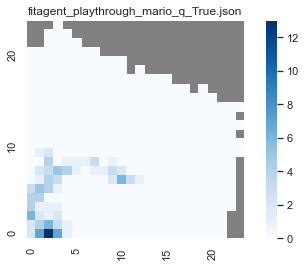

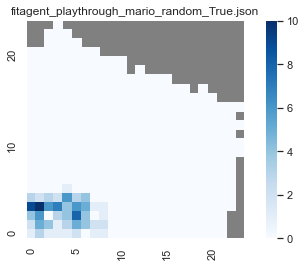

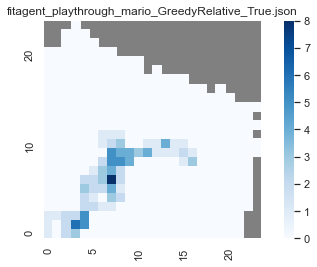

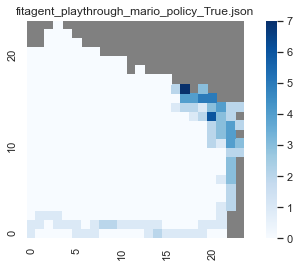

In [15]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

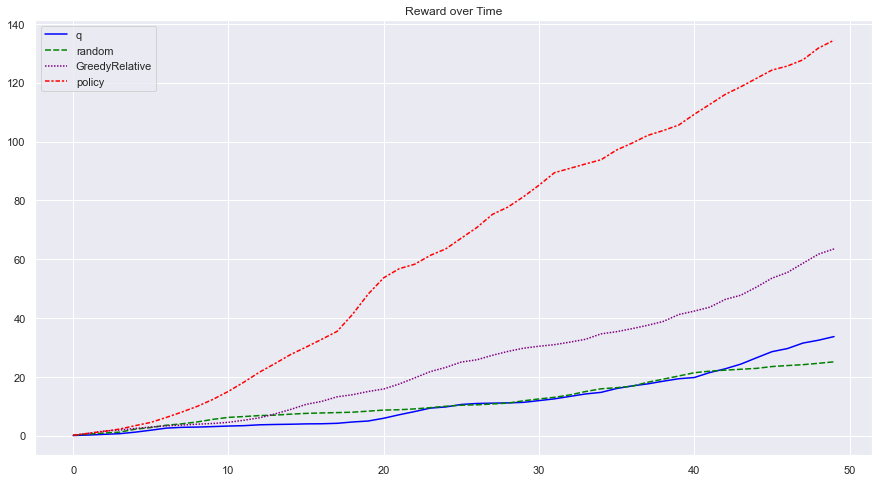

In [16]:
plot_reward_over_time(playthroughs)

## Agent ::  Icarus

In [17]:
config = Icarus
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config, True)

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


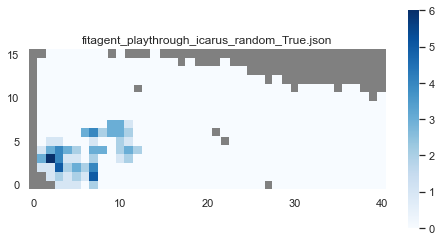

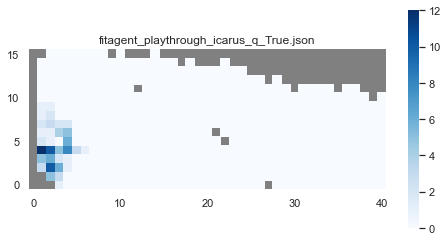

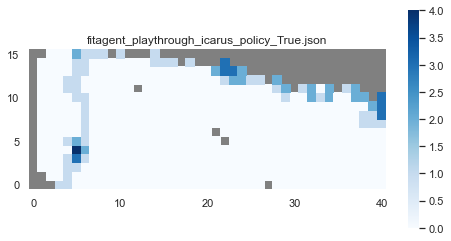

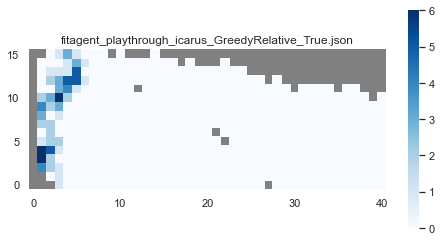

In [18]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

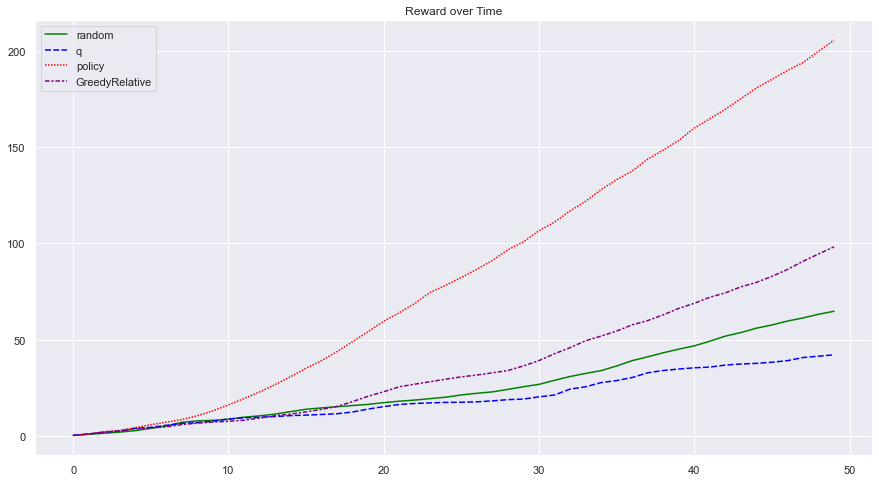

In [19]:
plot_reward_over_time(playthroughs)

# Player Personas

In [20]:
def get_all_player_playthroughs(config, allow_empty_link):
    playthroughs = []
    for path in glob(join(config.BASE_DIR, f'player_*_{allow_empty_link}.json')):
        path_split = path.split('/')[-1].split('_')
        player = path_split[1]
        director = path_split[-2]

        with open(path, 'r') as f:
            playthroughs.append((player, director, load(f)))

    return playthroughs

In [21]:
def get_df(playthroughs):
    data = []
    labels = ['Director', 'Player', 'Percent Complete', 'Player Reward', 'Design Reward','Total Reward']
    players = set()
    RUNS_SIZE = len(player_playthroughs[2][2][0])
    
    for player, director, run_data in playthroughs:
        players.add(player)
        for run in run_data:
            run_percent_complete = 0
            run_player_reward = 0
            run_design_reward = 0
            run_total_reward = 0

            for lvl in run:
                run_percent_complete += lvl['percent_complete']
                run_player_reward += lvl['percent_player_reward']
                run_design_reward += lvl['percent_design_reward']
                run_total_reward += lvl['percent_total_reward']
                    
            data.append((
                director, 
                player, 
                run_percent_complete / RUNS_SIZE, 
                run_player_reward / RUNS_SIZE, 
                run_design_reward / RUNS_SIZE, 
                run_total_reward / RUNS_SIZE))
            
    df = pd.DataFrame(data, columns=labels) \
         .groupby(['Player', 'Director']) \
         .agg(['mean', 'std']) \
         .sort_values(by=['Player', ('Total Reward', 'mean')], ascending=False)
    df = df.applymap("{0:.3f}".format)
    return df

In [22]:
def plot_player_personas_over_time(playthroughs, player_name):
    plot_data = []
    for player, alg, data in player_playthroughs:
        if player not in player_name:
            continue
            
        for session in data:
            total_reward = 0
            for i, lvl in enumerate(session):
                total_reward += lvl['percent_total_reward']
                plot_data.append((alg, i, total_reward))

    plot_df = pd.DataFrame(plot_data, columns=['alg', 'level', 'reward'])
    plot_df.alg.unique()

    sns.set(rc = {'figure.figsize':(15,8)})
    ax = sns.lineplot(data=plot_df, x='level', y='reward', hue='alg', palette=PALETTE)
    ax.set_title(f'Average Reward over Time for {player_name}')

    plt.show()

# Player Personas :: Mario

In [23]:
config = Mario
graph = Utility.get_graph(config, True)
player_playthroughs = get_all_player_playthroughs(config, True)
df = get_df(player_playthroughs)
mario_player_persona_table = df.to_latex() # store in case we want it
df

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


Percent Complete         \
                                                             mean    std   
Player                            Director                                 
Mediocre Player Likes High B      policy                    0.919  0.095   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
                                  q                         1.000  0.000   
Mediocre Player Likes High A      policy                    0.939  0.092   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
                                  q                         1.000  0.000   
Mediocre Player Likes Hard Levels policy                    0.952  0.070   
                                  q                         1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
Mediocre Player Likes Easy Levels random                    0.993  0.021   
                                  q                         1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  policy                    1.000  0.000   
Good Player Likes Hard Levels     policy                    1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
                                  q                         1.000  0.000   
Good Player Likes Easy Levels     random                    1.000  0.000   
                                  q                         1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  policy                    1.000  0.000   
Bad Player Likes Hard Levels      policy                    0.599  0.191   
                                  GreedyRelative            0.810  0.214   
                                  random                    0.852  0.167   
                                  q                         0.928  0.128   
Bad Player Likes Easy Levels      q                         0.886  0.204   
                                  GreedyRelative            0.965  0.112   
                                  random                    0.834  0.187   
                                  policy                    0.986  0.031   

                                                 Player Reward         \
                                                          mean    std   
Player                            Director                              
Mediocre Player Likes High B      policy                 0.281  0.057   
                                  GreedyRelative         0.124  0.057   
                                  random                 0.095  0.065   
                                  q                      0.111  0.069   
Mediocre Player Likes High A      policy                 0.356  0.106   
                                  GreedyRelative         0.143  0.078   
                                  random                 0.113  0.098   
                                  q                      0.094  0.048   
Mediocre Player Likes Hard Levels policy                 0.294  0.039   
                                  q                      0.126  0.055   
                                  GreedyRelative         0.125  0.032   
                                  random                 0.104  0.059   
Mediocre Player Likes Easy Levels random                 0.896  0.059   
                                  q                      0.902  0.036   
                                  GreedyRelative         0.922  0.026   
                                  policy                 0.941  0.026   
G

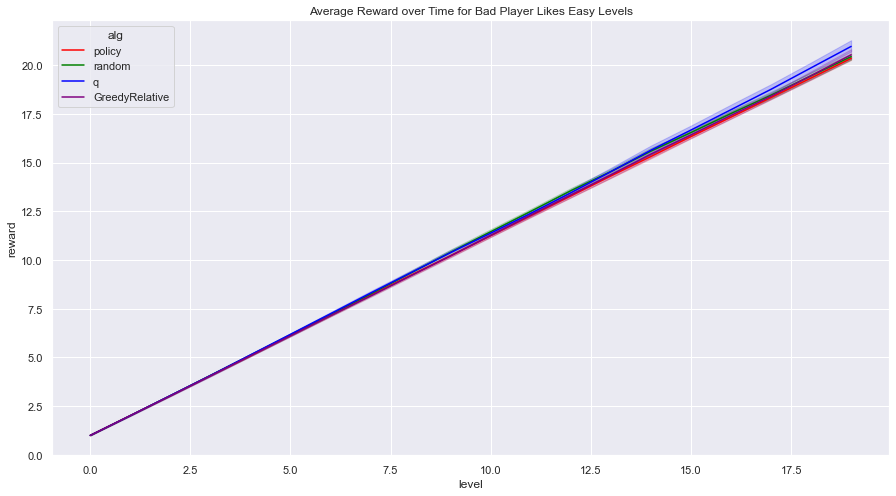

In [24]:
plot_player_personas_over_time(player_playthroughs, 'Bad Player Likes Easy Levels')

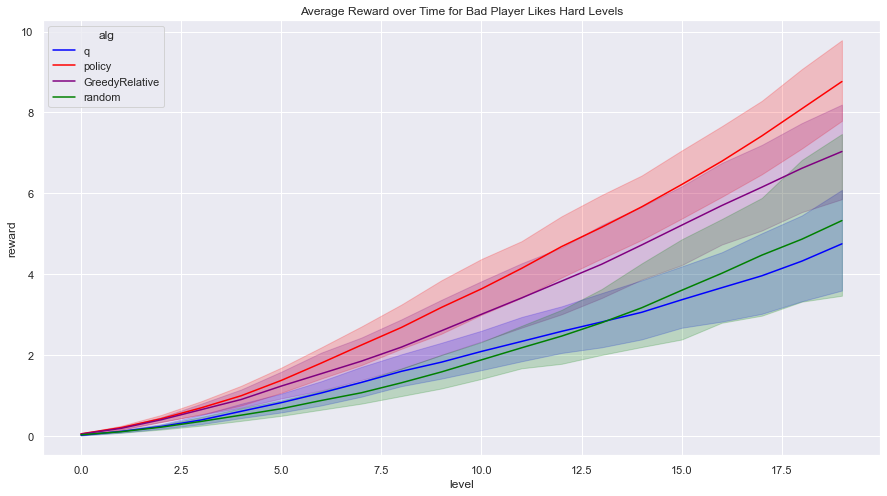

In [25]:
plot_player_personas_over_time(player_playthroughs, 'Bad Player Likes Hard Levels')

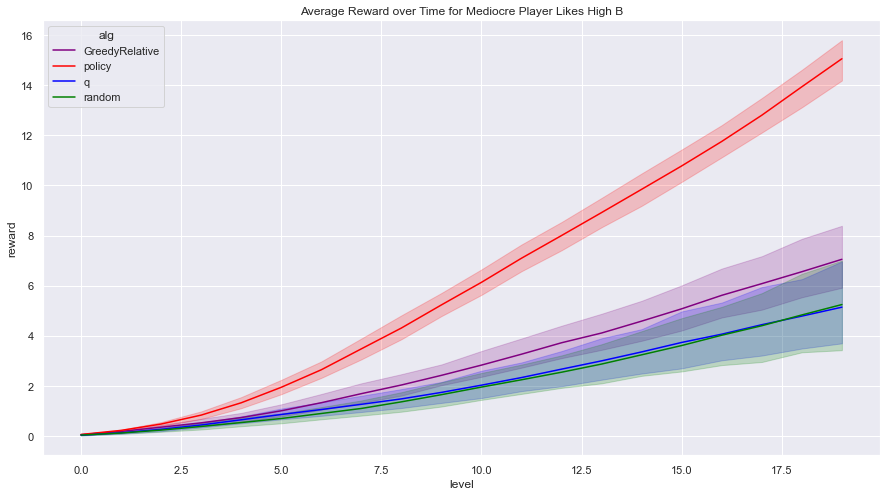

In [26]:
plot_player_personas_over_time(player_playthroughs, 'Mediocre Player Likes High B')

# Player Personas :: Icarus

In [27]:
config = Icarus
graph = Utility.get_graph(config, True)
playthroughs = get_all_player_playthroughs(config, True)
df = get_df(playthroughs)
icarus_player_persona_table = df.to_latex() # store in case we want it
df

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


Percent Complete         \
                                                             mean    std   
Player                            Director                                 
Mediocre Player Likes High B      policy                    0.977  0.032   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
                                  q                         1.000  0.000   
Mediocre Player Likes High A      policy                    0.984  0.030   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
                                  q                         1.000  0.000   
Mediocre Player Likes Hard Levels policy                    0.959  0.051   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
                                  q                         0.997  0.009   
Mediocre Player Likes Easy Levels random                    1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  q                         1.000  0.000   
                                  policy                    1.000  0.000   
Good Player Likes Hard Levels     policy                    1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
                                  q                         1.000  0.000   
Good Player Likes Easy Levels     random                    1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  policy                    1.000  0.000   
                                  q                         1.000  0.000   
Bad Player Likes Hard Levels      policy                    0.493  0.197   
                                  q                         0.799  0.227   
                                  GreedyRelative            0.828  0.149   
                                  random                    0.842  0.149   
Bad Player Likes Easy Levels      GreedyRelative            0.831  0.226   
                                  random                    0.823  0.168   
                                  policy                    0.969  0.063   
                                  q                         0.935  0.139   

                                                 Player Reward         \
                                                          mean    std   
Player                            Director                              
Mediocre Player Likes High B      policy                 0.133  0.045   
                                  GreedyRelative         0.104  0.043   
                                  random                 0.096  0.019   
                                  q                      0.098  0.026   
Mediocre Player Likes High A      policy                 0.489  0.111   
                                  GreedyRelative         0.242  0.135   
                                  random                 0.189  0.095   
                                  q                      0.127  0.044   
Mediocre Player Likes Hard Levels policy                 0.313  0.037   
                                  GreedyRelative         0.160  0.050   
                                  random                 0.142  0.046   
                                  q                      0.139  0.047   
Mediocre Player Likes Easy Levels random                 0.858  0.046   
                                  GreedyRelative         0.877  0.034   
                                  q                      0.878  0.023   
                                  policy                 0.857  0.020   
G

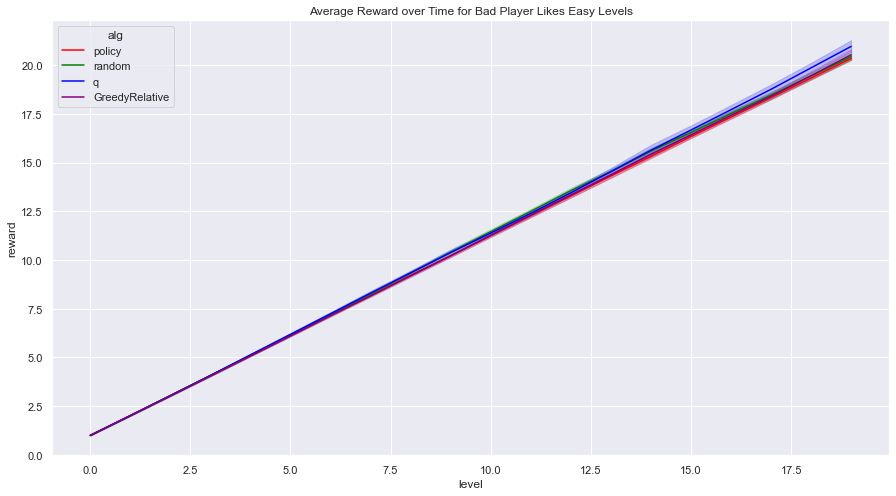

In [28]:
plot_player_personas_over_time(player_playthroughs, 'Bad Player Likes Easy Levels')

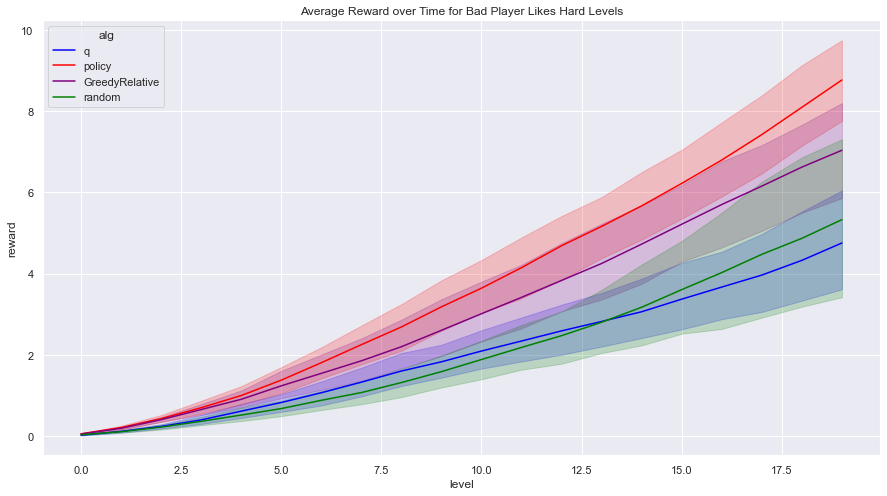

In [29]:
plot_player_personas_over_time(player_playthroughs, 'Bad Player Likes Hard Levels')

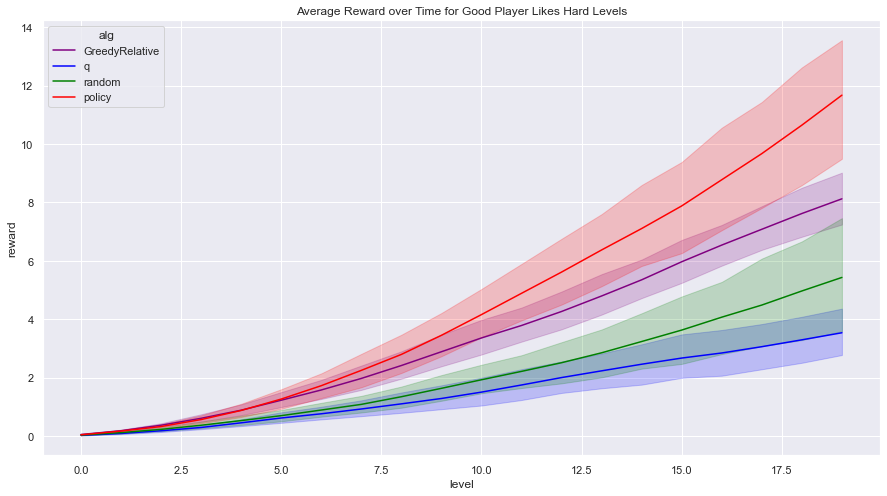

In [30]:
plot_player_personas_over_time(player_playthroughs, 'Good Player Likes Hard Levels')

# Player Personas :: DungeonGrams

In [31]:
config = DungeonGrams
graph = Utility.get_graph(config, True)
playthroughs = get_all_player_playthroughs(config, True)
df = get_df(playthroughs)
dg_player_persona_table = df.to_latex() # store in case we want it
df

Loading links from: ./GramElitesData/DungeonData/gram_elites/links_True.json


Percent Complete         \
                                                             mean    std   
Player                            Director                                 
Mediocre Player Likes High B      policy                    0.975  0.032   
                                  GreedyRelative            1.000  0.000   
                                  random                    1.000  0.000   
                                  q                         1.000  0.000   
Mediocre Player Likes High A      policy                    0.996  0.013   
                                  GreedyRelative            1.000  0.000   
                                  q                         1.000  0.000   
                                  random                    1.000  0.000   
Mediocre Player Likes Hard Levels policy                    0.956  0.056   
                                  GreedyRelative            0.987  0.040   
                                  random                    1.000  0.000   
                                  q                         1.000  0.000   
Mediocre Player Likes Easy Levels q                         0.965  0.076   
                                  random                    0.992  0.018   
                                  GreedyRelative            0.996  0.012   
                                  policy                    1.000  0.000   
Good Player Likes Hard Levels     policy                    1.000  0.000   
                                  GreedyRelative            1.000  0.000   
                                  q                         1.000  0.000   
                                  random                    1.000  0.000   
Good Player Likes Easy Levels     q                         1.000  0.000   
                                  policy                    1.000  0.000   
                                  random                    1.000  0.000   
                                  GreedyRelative            1.000  0.000   
Bad Player Likes Hard Levels      policy                    0.425  0.120   
                                  GreedyRelative            0.806  0.216   
                                  q                         0.808  0.261   
                                  random                    0.824  0.208   
Bad Player Likes Easy Levels      q                         0.624  0.283   
                                  GreedyRelative            0.900  0.169   
                                  policy                    0.892  0.141   
                                  random                    0.807  0.227   

                                                 Player Reward         \
                                                          mean    std   
Player                            Director                              
Mediocre Player Likes High B      policy                 0.313  0.148   
                                  GreedyRelative         0.136  0.066   
                                  random                 0.136  0.107   
                                  q                      0.138  0.098   
Mediocre Player Likes High A      policy                 0.336  0.135   
                                  GreedyRelative         0.147  0.051   
                                  q                      0.142  0.109   
                                  random                 0.128  0.080   
Mediocre Player Likes Hard Levels policy                 0.270  0.071   
                                  GreedyRelative         0.171  0.071   
                                  random                 0.132  0.060   
                                  q                      0.117  0.046   
Mediocre Player Likes Easy Levels q                      0.855  0.065   
                                  random                 0.868  0.061   
                                  GreedyRelative         0.876  0.035   
                                  policy                 0.878  0.054   
G

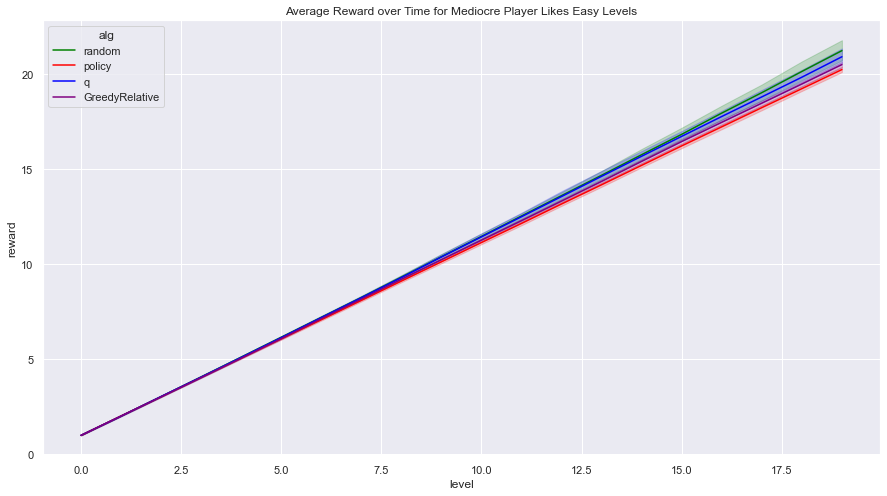

In [32]:
plot_player_personas_over_time(player_playthroughs, 'Mediocre Player Likes Easy Levels')

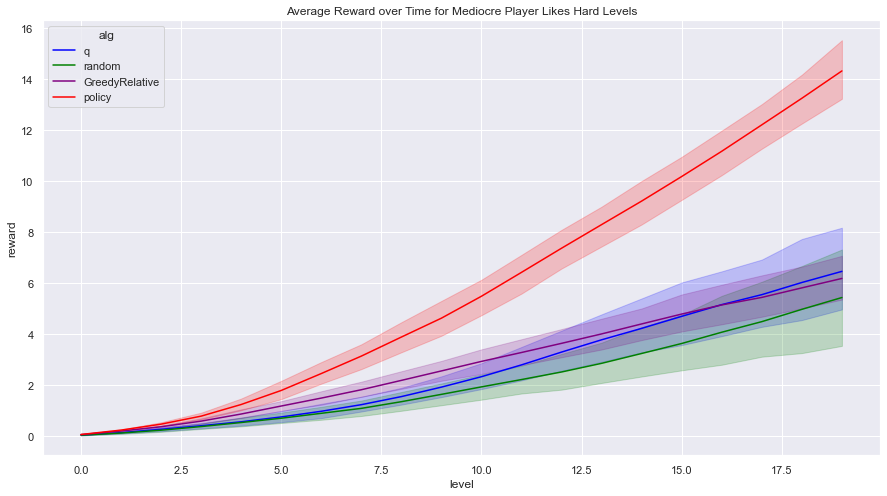

In [33]:
plot_player_personas_over_time(player_playthroughs, 'Mediocre Player Likes Hard Levels')

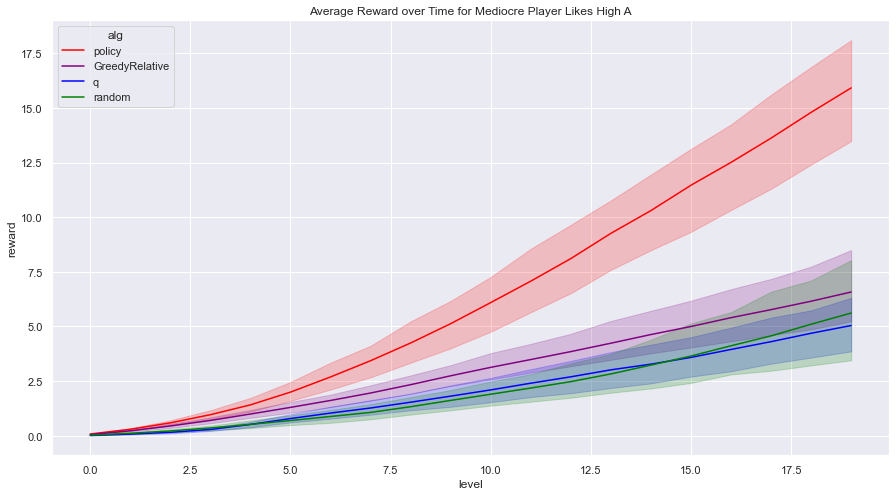

In [34]:
plot_player_personas_over_time(player_playthroughs, 'Mediocre Player Likes High A')